# [Building makemore part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I)

how do we determine how to tokenize? unsupervised?

embed each word in a high-dimensional space

tune the embedding in the high-dimensional space with back-propagation. this is wicked cool. I don't think I've ever learned this part.

transfer knowledge because even if you are out of distribution you can find similar examples with words nearby in the embedding space.

C is a lookup table that gives the vector in the embedding space for a given word.

once we get our embedding space vectors for the whole context, the model is structurally the same as in the previous videos.

In [79]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
words = open('names.txt', 'r').read().splitlines()

In [81]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [82]:
block_size = 3 # context length.
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [83]:
C = torch.randn((27,2))

In [84]:
C[5]

tensor([-0.4930,  0.6032])

In [85]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([-0.4930,  0.6032])

In [86]:
emb = C[X] # this is crazy lit.

In [87]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [88]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1).shape # clunky because not general.

torch.Size([228146, 6])

In [ ]:
torch.cat(torch.unbind(emb, 1), 1).shape # pretty fire but apparently not optimal.

torch.Size([228146, 6])

all PyTorch vectors are stored in memory as 1-dimensional lists. there is an attribute of that list to show how that 1-d list folds up to make an n-dimensional tensor.

In [ ]:
emb.view(32,6) # this is the most fire line of code I have written in a good while. PyTorch is gas. this will give me the juice to finish this tutorial tonight.

RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # each row of this is the hidden layer activations for the corresponding context.

In [ ]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()

In [ ]:
probs = counts / counts.sum(1, keepdims = True)

In [ ]:
loss = -probs[torch.arange(32), Y].log().mean()
loss.item()

19.132400512695312

In [95]:
# make it respectable:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [96]:
sum(p.nelement() for p in parameters) # count the total number of parameters.

11897

In [97]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [98]:
for p in parameters:
    p.requires_grad = True

In [99]:
lri = []
lossi = []
stepi = []

In [111]:
for i in range(50000):
    # make minibatch.
    ix = torch.randint(5, Xtr.shape[0], (32,))
    
    # forward pass.
    emb = C[Xtr[ix]] # still makes me feel cool.
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass.
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update.
    for p in parameters:
        p.data += 0.01 * -p.grad
        
    # statz.
    stepi.append(i)
    lossi.append(loss.item())

2.3010165691375732


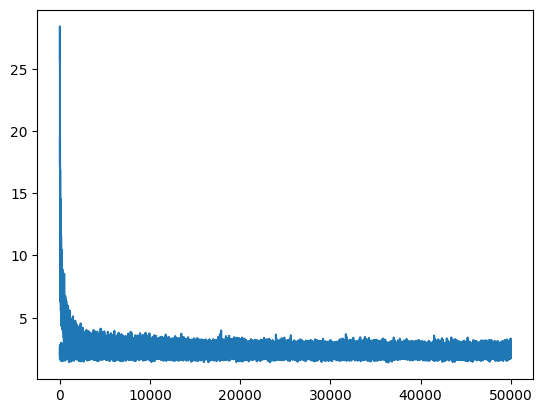

In [112]:
plt.plot(stepi, lossi)

In [113]:
emb = C[Xdev] # still makes me feel cool.
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(2.2100, grad_fn=<NllLossBackward0>)


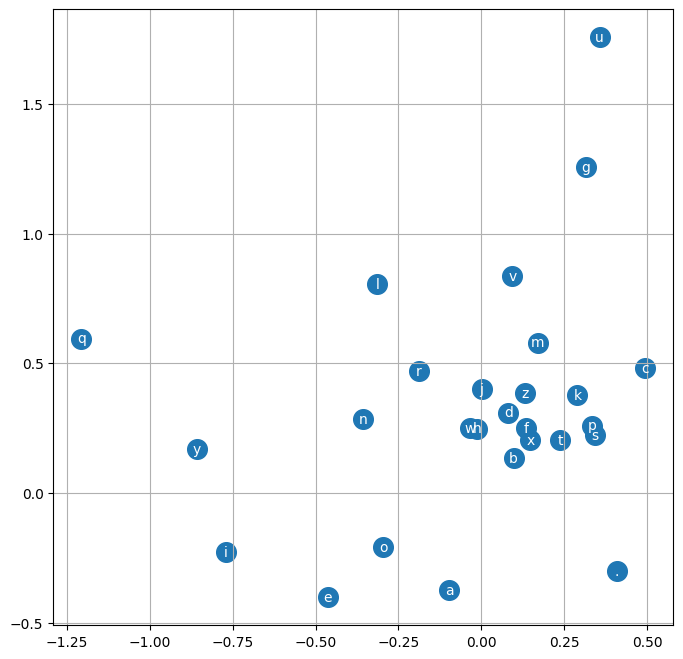

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# copied and pasted. very straightforward. can't be asked.

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [115]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

phad.
mal.
kelo.
rise.
carlana.
saila.
brianyiriquaviestalesa.
dhey.
renly.
daiida.
hailah.
dofie.
ocjlanaistine.
daya.
emirionnanna.
ter.
olk.
rabotush.
knillen.
nican.


these new outputs are great